In [67]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

from sklearn.datasets import make_moons, load_iris
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

# Voting Classifiers

**Hard Voting** is when an ensemble uses a majority vote for classification.

**Soft Voting** is when an ensemble uses the maximum class probability averaged across the individual classifiers for classification.

#### Toy Example

In [21]:
X,y = make_moons(n_samples=500, noise=0.3)
X_train, X_test, y_train, y_test = train_test_split(X,y)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression()),
        ('rf', RandomForestClassifier()),
        ('svc', SVC())
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [22]:
for name,clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

print('voting_clf', "=", voting_clf.score(X_test, y_test))

lr = 0.848
rf = 0.912
svc = 0.904
voting_clf = 0.904


In [24]:
## VotinVotingClassifier defaults to hard voting. To be soft, each classifier must use probability for prediction.

voting_clf.voting = 'soft'
voting_clf.named_estimators['svc'].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.912

# Bagging and Pasting

A different ensemble approach is to use a single model type for every predictor but trained on different random subsets of the training set.

**Bagging** is sampling _with_ replacement - short for **b**ootstrap **ag**gregating.\
**Pasting** is sampling _without_ replacement.

**Note 1:** BaggingClassifier automatically performs soft voting if the base classifier can estimate class probabilities.\
**Note 2:** RandomForestClassifier is a specialized version of BaggingClassifier where the model is DecisionTreeClassifiers.

#### Toy Example

In [32]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, n_jobs=-1)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1)

<Axes: >

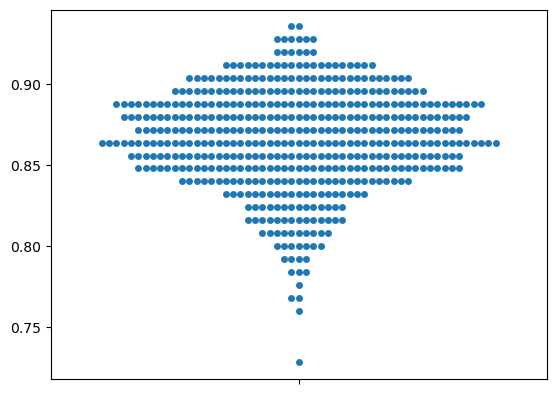

In [41]:
scores = []
for i in bag_clf.estimators_:
    scores.append(i.score(X_test, y_test))

sns.swarmplot(scores)

In [42]:
### The aggregate outperforms the vast majority of individual models.
bag_clf.score(X_test, y_test)

0.92

## Out-of-Bag Evaluation (OOB)

Asymptotically, when sampling with replacementabout $63\%$ of training instances are sampled on average for each predictor. The remaining instances that are not sampled are called out-of-bag instances. You can treat these instances as a validation set.

In [45]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)

print("OOB Validation Score", "=", bag_clf.oob_score_)
print("Test Data Score", "=", accuracy_score(y_test, bag_clf.predict(X_test)))

OOB Validation Score = 0.9226666666666666
Test Data Score = 0.92


## Random Patches and Random Subspaces

Instead of training predictors on samples from the training data, it is possible to sample **features** of the dataset for training. This can speed things up considerably when dealing with high-dimensional inputs (such as images).

**Random Patches** is sampling both training instances and features.\
**Random Subspaces** is sampling for features and training on all instances.

## Feature Importance (RandomForest)

The RandomForestClassifier provides information on the importance of each feature in classification while growing the trees. This is captured in the feature_importances_ variable.

A toy example:

In [50]:
iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score,2)*100, "% importance from", name)

11.0 % importance from sepal length (cm)
3.0 % importance from sepal width (cm)
42.0 % importance from petal length (cm)
44.0 % importance from petal width (cm)


# Boosting

Boosting refers to an ensemble method that combines several weak learners into a strong learner. The general idea is to train predictors sequentially, each trying to correct its predecessor.

## AdaBoost

**Ada**ptive **Boost**ing is a boosting technique. First a base classifier is trained and is used to make predictions on the training set. The algorithm then increases the relative weight of misclassified training instances. Then it trains a second classifier, using the updated weights, and makes prediction on the training set, updating the misclassified instance weights. Rinse and repeat.

In [59]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=30, learning_rate=0.25)
ada_clf.fit(X_train, y_train)

ada_clf.score(X_test, y_test)

0.928

## Gradient Boosting

In [69]:
X = np.random.rand(100,1) - 0.5
y = 3*X[:,0]**2 +0.05*np.random.randn(100)

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

y3 = y - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

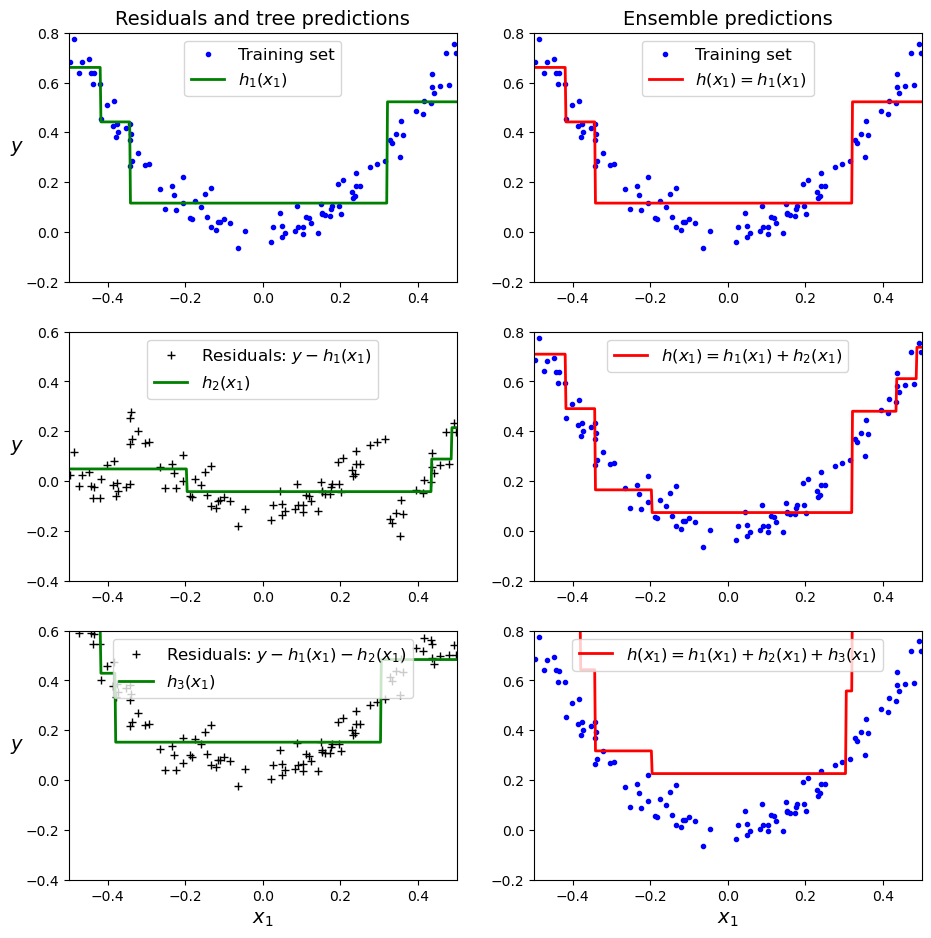

In [71]:
def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

plt.show()